In [1]:
%config IPCompleter.greedy=True

In [2]:
import sys
sys.path.append("../..") # relative path to module toolkit

In [3]:
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from toolkit import getLabelsFromDir, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight 
from keras import optimizers
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
# setup
batch_size = 3
train_dir = "../../../images/images_species/train/"
val_dir = "../../../images/images_species/val/"
train_images = 12263
val_images = 3381
save_plot_name = "trainplot.png"
model_name = 'highest_val_acc.h5'

optimizer = optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [5]:
steps_per_epoch = int(train_images/batch_size) + 1
validation_steps = int(val_images/batch_size) + 1

In [6]:
### Model building ####

base_model = ResNet50(
            include_top=False,
            input_shape=(224, 224, 3),
            weights="imagenet")

#add a new dense layer to the end of the network inplace of the old layers
x = base_model.output
x = GlobalAveragePooling2D()(x)

# add the outplut layer
predictions = Dense(200, activation='softmax')(x)

# create new model composed of pre-trained network and new final layers
model = Model(input=base_model.input, output=predictions)

for layer in model.layers:
    layer.trainable = True

/home/herri/.local/lib/python3.5/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/home/herri/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  app.launch_new_instance()


In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [8]:

# compile model
model.compile(loss='categorical_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])


In [9]:
labels = getLabelsFromDir(train_dir)

train_datagen = ImageDataGenerator(rescale=1./255.)
val_datagen = ImageDataGenerator(rescale=1./255.)

In [10]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    shuffle=True)
val_generator = val_datagen.flow_from_directory(val_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    shuffle=True)

Found 12263 images belonging to 200 classes.
Found 3381 images belonging to 200 classes.


In [11]:
filepath = model_name

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

early_stop = EarlyStopping(monitor='val_acc', mode='max', patience=10)

callbacks = [checkpoint, early_stop]

In [12]:
the_class_weight = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

In [13]:
#Train
history = model.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=5000,
                    callbacks=callbacks,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    class_weight=the_class_weight)

Epoch 1/5000
4088/4088 [==============================] - 490s 120ms/step - loss: 3.8309 - acc: 0.2162 - val_loss: 2.2531 - val_acc: 0.4524

Epoch 00001: val_acc improved from -inf to 0.45242, saving model to highest_val_acc.h5
Epoch 2/5000
4088/4088 [==============================] - 479s 117ms/step - loss: 1.9424 - acc: 0.5611 - val_loss: 1.1623 - val_acc: 0.6720

Epoch 00002: val_acc improved from 0.45242 to 0.67199, saving model to highest_val_acc.h5
Epoch 3/5000
4088/4088 [==============================] - 484s 118ms/step - loss: 1.0361 - acc: 0.7647 - val_loss: 0.8116 - val_acc: 0.7544

Epoch 00003: val_acc improved from 0.67199 to 0.75443, saving model to highest_val_acc.h5
Epoch 4/5000
4088/4088 [==============================] - 486s 119ms/step - loss: 0.6002 - acc: 0.8606 - val_loss: 0.7117 - val_acc: 0.7931

Epoch 00004: val_acc improved from 0.75443 to 0.79314, saving model to highest_val_acc.h5
Epoch 5/5000
4088/4088 [==============================] - 486s 119ms/step - los

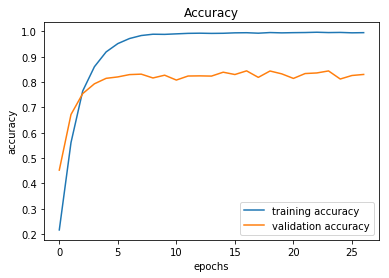

In [14]:
plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig(save_plot_name, bbox_inches='tight')
plt.show()